In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

In [2]:
public = pd.read_csv('./ready/public_media_vaccine.csv', encoding='utf-8-sig')
civil = pd.read_csv('./ready/civil_platform_vaccine.csv', encoding='utf-8-sig')

emotion_groups_ekman = {
    'Happiness': ['joy', 'amusement', 'excitement', 'pride', 'gratitude', 'relief', 'love', 'caring'],
    'Sadness': ['sadness', 'disappointment', 'remorse', 'grief'],
    'Anger': ['anger', 'annoyance', 'disapproval'],
    'Fear': ['fear', 'nervousness'],
    'Disgust': ['disgust', 'embarrassment'],
    'Surprise': ['surprise', 'realization', 'confusion'],
}

def process_platform_emotions(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce').dt.tz_localize(None)
    df = df.dropna(subset=[date_col])
    df['week'] = df[date_col].dt.to_period('W').apply(lambda r: r.start_time)

    for group, emotions in emotion_groups_ekman.items():
        df[group] = df[emotions].mean(axis=1)

    weekly_df = df.groupby('week')[list(emotion_groups_ekman.keys())].mean().reset_index()
    return weekly_df

weekly_public = process_platform_emotions(public, 'pub_date')
weekly_civil = process_platform_emotions(civil, 'pub_date')

In [3]:
# 감정 그룹 정의
emotion_groups = ['Happiness', 'Sadness', 'Anger', 'Fear', 'Disgust', 'Surprise']

# Soft Transition Matrix 함수
def compute_soft_transition_matrix(df, emotions):
    transitions = np.zeros((len(emotions), len(emotions)))

    for t in range(len(df) - 1):
        from_vec = df.loc[t, emotions].astype(float).values
        to_vec = df.loc[t + 1, emotions].astype(float).values
        transitions += np.outer(from_vec, to_vec)

    matrix = transitions / transitions.sum(axis=1, keepdims=True)
    return pd.DataFrame(matrix, index=emotions, columns=emotions)

# 시각화 함수
def plot_transition_heatmap(matrix, title="Soft Emotion Transition Matrix"):
    plt.figure(figsize=(7, 5))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.ylabel("Current Emotion (t)")
    plt.xlabel("Next Emotion (t+1)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

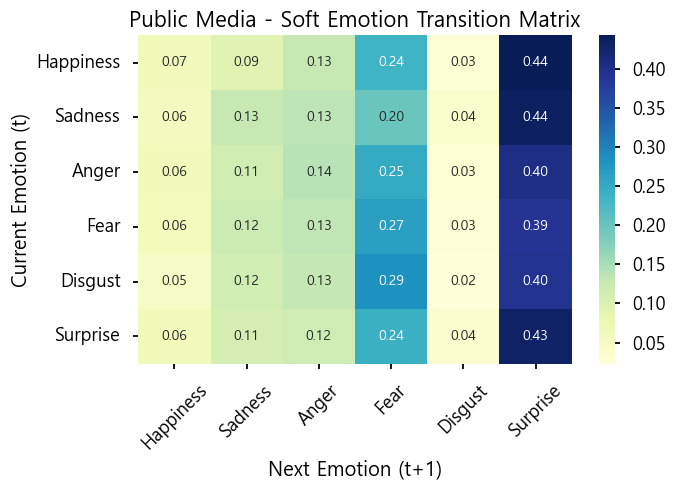

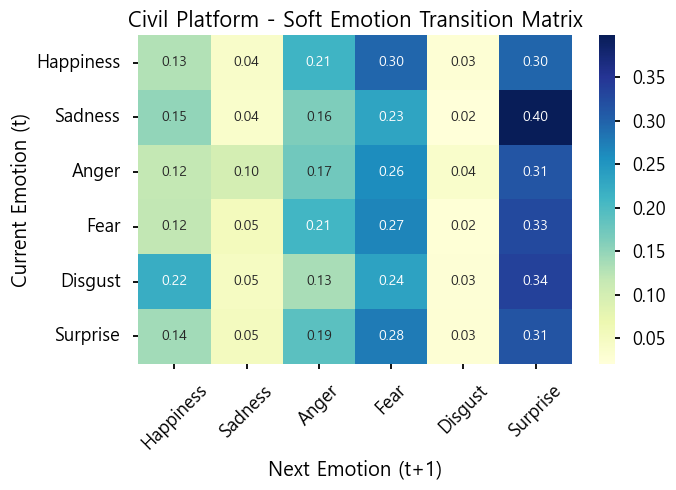

In [10]:
# Public Media
public_matrix = compute_soft_transition_matrix(weekly_public, emotion_groups)
plot_transition_heatmap(public_matrix, title="Public Media - Soft Emotion Transition Matrix")

# Civil Platform
civil_matrix = compute_soft_transition_matrix(weekly_civil, emotion_groups)
plot_transition_heatmap(civil_matrix, title="Civil Platform - Soft Emotion Transition Matrix")

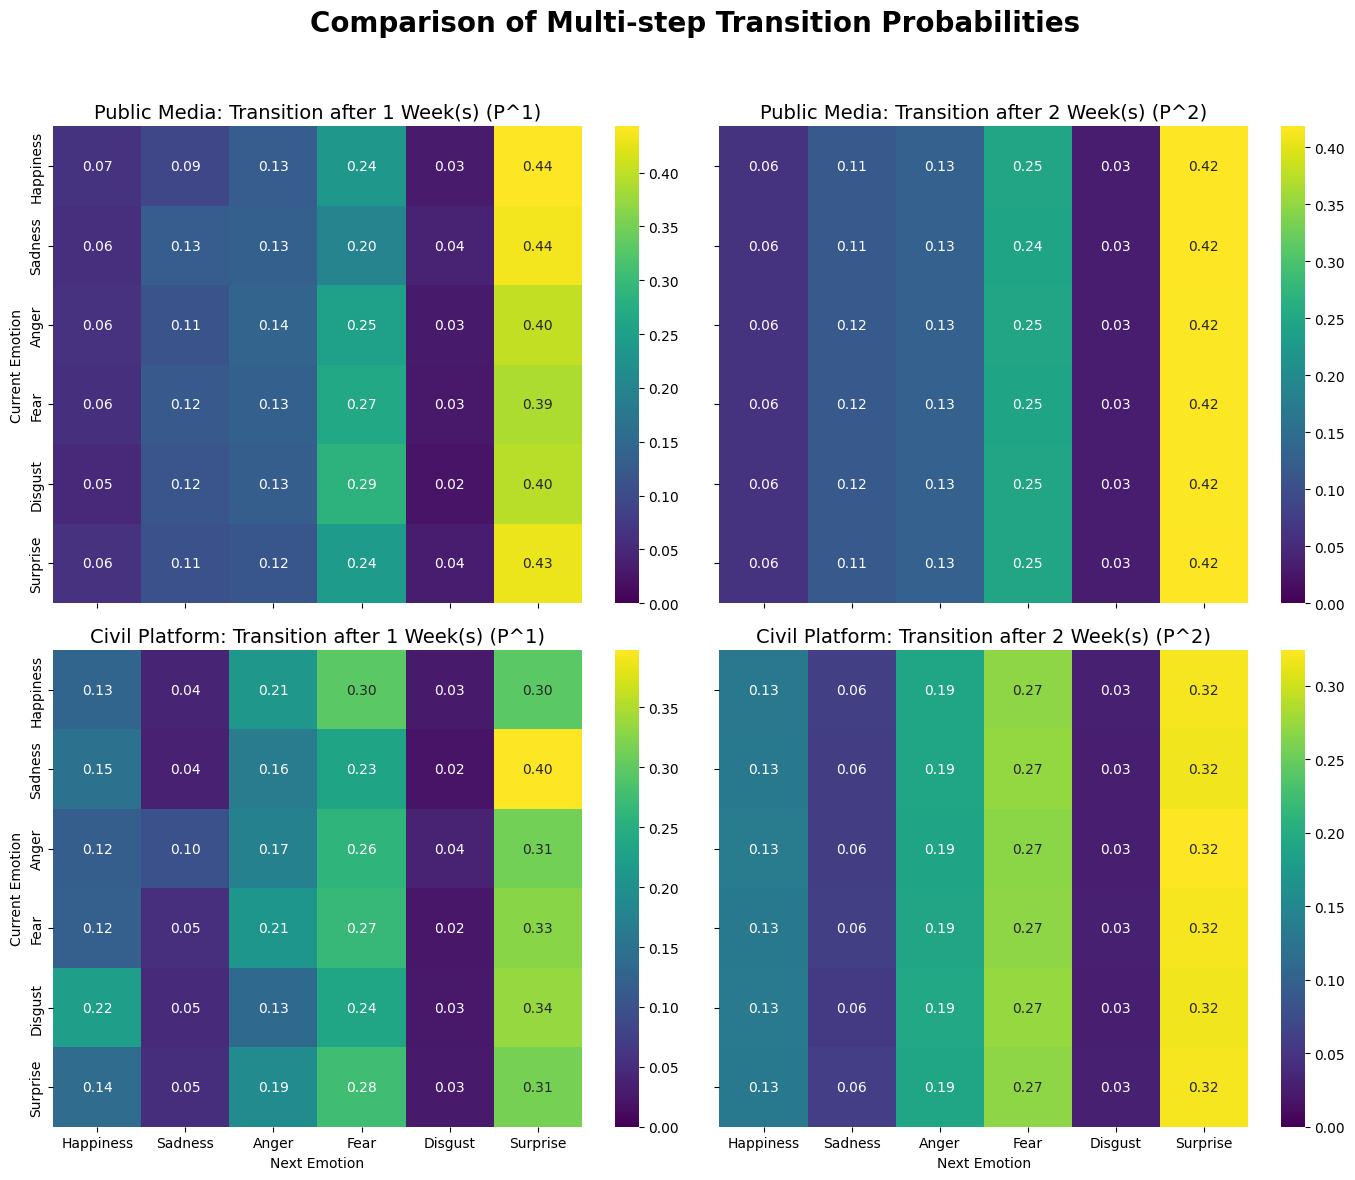

In [5]:
def plot_combined_multistep_transitions(matrix1, matrix2, title1, title2, max_steps=2):
    """
    두 플랫폼의 N-step 전이 확률을 하나의 Figure(2xN 그리드)에 비교하여 시각화합니다.
    """
    # 2x2 그리드 생성
    fig, axes = plt.subplots(2, max_steps, figsize=(14, 12), sharex=True, sharey=True)
    fig.suptitle('Comparison of Multi-step Transition Probabilities', fontsize=20, fontweight='bold')

    matrices = [matrix1, matrix2]
    titles = [title1, title2]

    # 각 플랫폼(행)에 대해 반복
    for i in range(2):
        base_matrix = matrices[i]
        
        # 각 스텝(열)에 대해 반복
        for n in range(1, max_steps + 1):
            ax = axes[i, n-1]

            # P^n 계산
            multi_step_matrix = np.linalg.matrix_power(base_matrix.values, n)
            multi_step_df = pd.DataFrame(multi_step_matrix, index=base_matrix.index, columns=base_matrix.columns)

            # 히트맵 그리기
            sns.heatmap(multi_step_df, annot=True, fmt=".2f", cmap="viridis", ax=ax, vmin=0)

            # 제목 및 레이블 설정
            ax.set_title(f'{titles[i]}: Transition after {n} Week(s) (P^{n})', fontsize=14)
            if i == 1:  # 아래쪽 행에만 X축 레이블 표시
                ax.set_xlabel("Next Emotion")
            else:
                ax.set_xlabel("")

            if n == 1:  # 왼쪽 열에만 Y축 레이블 표시
                ax.set_ylabel("Current Emotion")
            else:
                ax.set_ylabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 분석 1: Public Media와 Civil Platform의 다중 단계 전이 확률을 하나의 Figure로 시각화
plot_combined_multistep_transitions(public_matrix, civil_matrix, "Public Media", "Civil Platform")


--- Calculating Mean First Passage Times for Both Platforms ---

[Public Media MFPT Matrix (Weeks)]
           Happiness  Sadness  Anger  Fear  Disgust  Surprise
Happiness      16.21    17.68  15.70  8.28    60.27      4.77
Sadness        32.53     8.69  15.66  8.43    59.96      4.78
Anger          32.47    17.50   7.81  8.22    60.34      4.87
Fear           32.49    17.43  15.66  4.08    60.40      4.90
Disgust        32.66    17.48  15.69  8.08    30.28      4.89
Surprise       32.47    17.53  15.79  8.25    60.18      2.40

[Civil Platform MFPT Matrix (Weeks)]
           Happiness  Sadness  Anger  Fear  Disgust  Surprise
Happiness       7.62    33.68  10.24  7.32    71.62      6.29
Sadness        15.07    16.89  10.48  7.54    71.87      5.98
Anger          15.30    32.74   5.22  7.46    71.27      6.23
Fear           15.31    33.45  10.25  3.71    71.73      6.20
Disgust        14.52    33.63  10.62  7.53    35.86      6.18
Surprise       15.15    33.50  10.35  7.39    71.63    

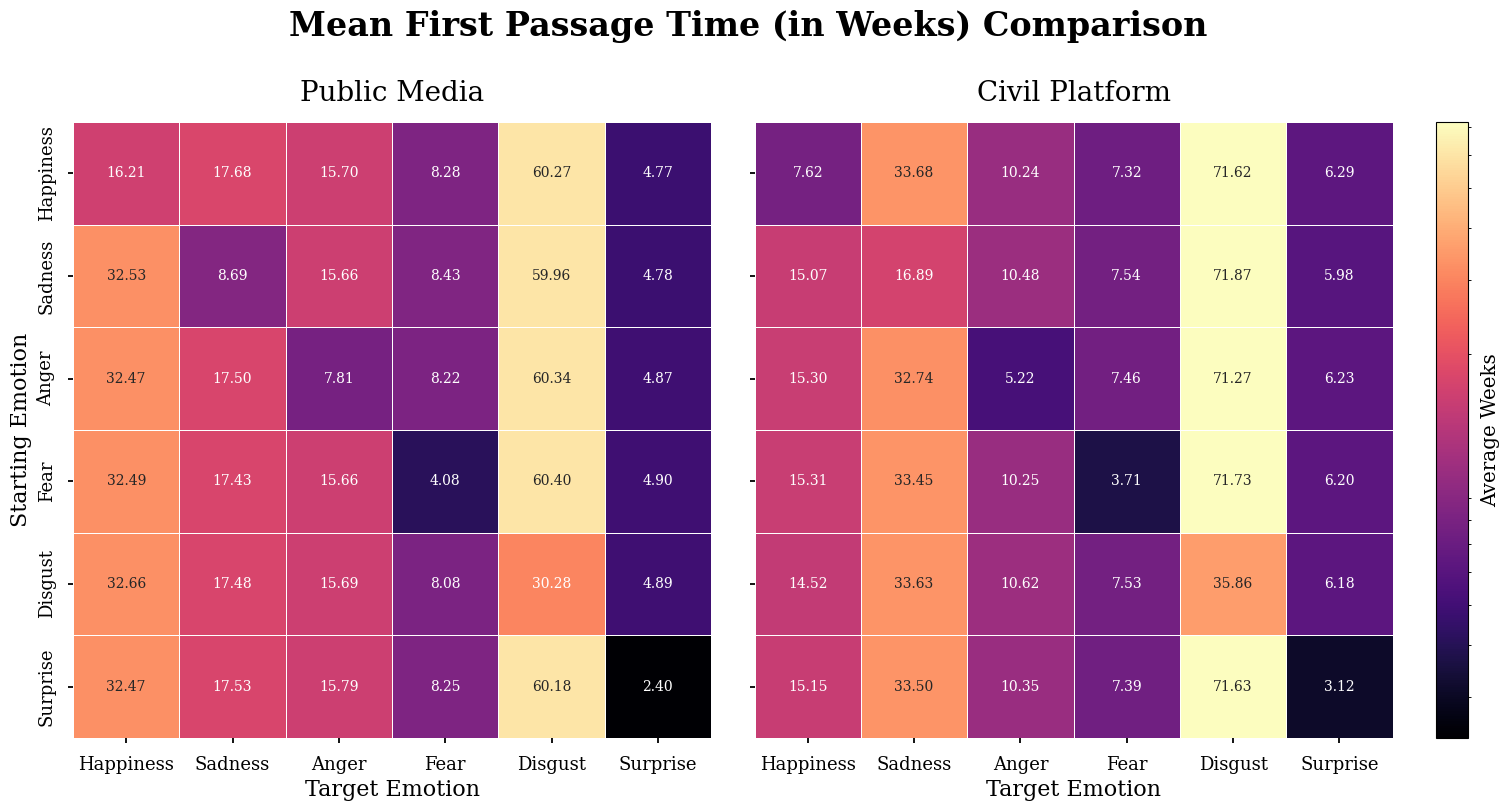

In [6]:
from typing import List
from matplotlib.colors import LogNorm

# --------------------------------------------------------------------------------------
# 🎨 1. 시각화 스타일 및 폰트 설정 (개선된 부분)
# --------------------------------------------------------------------------------------
# 발표/논문에 적합한 seaborn 스타일과 깔끔한 폰트를 설정합니다.
plt.style.use('seaborn-v0_8-talk')
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# --------------------------------------------------------------------------------------
# 🧮 2. 핵심 계산 함수 (Type Hinting 추가)
# --------------------------------------------------------------------------------------
def calculate_stationary_distribution(P: np.ndarray) -> np.ndarray:
    """전이 행렬 P로부터 정상 분포(stationary distribution)를 계산합니다."""
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    pi_vector = eigenvectors[:, np.isclose(eigenvalues, 1)].flatten().real
    return pi_vector / pi_vector.sum()

def calculate_mean_first_passage_time(P: pd.DataFrame) -> pd.DataFrame:
    """전이 행렬 P로부터 평균 도달 시간(MFPT) 행렬 M을 계산합니다."""
    n_states = P.shape[0]
    pi = calculate_stationary_distribution(P.values)
    W = np.tile(pi, (n_states, 1))
    I = np.identity(n_states)
    Z = np.linalg.inv(I - P.values + W)
    E = np.ones((n_states, n_states))
    Z_dg = np.diag(np.diag(Z))
    D = np.diag(1 / pi)
    M = (E - Z + E @ Z_dg) @ D
    np.fill_diagonal(M, 1 / pi)
    return pd.DataFrame(M, index=P.index, columns=P.columns)


import matplotlib.gridspec as gridspec # GridSpec import 추가

# ... (다른 함수들은 그대로 유지) ...

# --------------------------------------------------------------------------------------
# 📊 3. 개선된 시각화 함수 (GridSpec 적용)
# --------------------------------------------------------------------------------------
def plot_comparison_mfpt_heatmap(
    matrix1: pd.DataFrame,
    matrix2: pd.DataFrame,
    title1: str,
    title2: str
):
    """두 플랫폼의 MFPT 행렬을 '동일한 너비'와 '로그 스케일'로 비교하는 히트맵을 생성합니다."""
    
    fig = plt.figure(figsize=(18, 8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[20, 20, 1], wspace=0.1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    cax = fig.add_subplot(gs[0, 2])

    fig.suptitle('Mean First Passage Time (in Weeks) Comparison', fontsize=24, fontweight='bold', y=1.02)

    # --- 👇 이 부분 수정 ---
    # LogNorm 객체를 생성합니다. vmin은 0보다 커야 하므로 작은 값을 넣어줍니다.
    norm = LogNorm(vmin=min(matrix1.min().min(), matrix2.min().min()), vmax=max(matrix1.max().max(), matrix2.max().max()))
    # --- 👆 여기까지 ---
    
    # 첫 번째 히트맵 (Public Media)
    sns.heatmap(
        matrix1, annot=True, fmt=".2f", cmap="magma", linewidths=.5,
        ax=ax1, cbar=False,
        norm=norm # norm 파라미터 적용
    )
    ax1.set_title(title1, fontsize=20, pad=15)
    ax1.set_xlabel("Target Emotion", fontsize=16)
    ax1.set_ylabel("Starting Emotion", fontsize=16)

    # 두 번째 히트맵 (Civil Platform)
    sns.heatmap(
        matrix2, annot=True, fmt=".2f", cmap="magma", linewidths=.5,
        ax=ax2, cbar=False,
        norm=norm # norm 파라미터 적용
    )
    ax2.set_title(title2, fontsize=20, pad=15)
    ax2.set_xlabel("Target Emotion", fontsize=16)
    plt.setp(ax2.get_yticklabels(), visible=False)

    # 컬러바
    mappable = ax1.collections[0]
    fig.colorbar(mappable, cax=cax, label='Average Weeks')
    cax.yaxis.set_ticks([])
    cax.yaxis.set_ticklabels([])
    
    plt.savefig('Figure7.svg', dpi=300, bbox_inches='tight')
    plt.savefig('Figure7.png', dpi=300, bbox_inches='tight')
    plt.show()
    

# --------------------------------------------------------------------------------------
# 🚀 4. 메인 실행 블록 (표준 구조 적용)
# --------------------------------------------------------------------------------------
if __name__ == '__main__':

    # 분석 1: 평균 도달 시간 계산
    print("\n--- Calculating Mean First Passage Times for Both Platforms ---")
    mfpt_public = calculate_mean_first_passage_time(public_matrix)
    mfpt_civil = calculate_mean_first_passage_time(civil_matrix)

    print("\n[Public Media MFPT Matrix (Weeks)]")
    print(mfpt_public.round(2))
    print("\n[Civil Platform MFPT Matrix (Weeks)]")
    print(mfpt_civil.round(2))

    # 분석 2: 두 플랫폼의 평균 도달 시간 비교 시각화
    plot_comparison_mfpt_heatmap(mfpt_public, mfpt_civil, "Public Media", "Civil Platform")

## New Visualization

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def create_fully_manual_sankey(
    civil_matrix,
    public_matrix,
    source_y_positions,
    civil_target_y_positions,
    public_target_y_positions,
    threshold=0.1
):
    """
    Sankey의 모든 노드 y좌표를 개별적으로 지정하여 생성합니다.
    """
    color_map = {
        'Happiness': '#FFCC00',
        'Sadness':   '#1A4F8B',
        'Anger':     '#C62828',
        'Fear':      '#455A64',
        'Disgust':   '#6B8E23',
        'Surprise':  '#9C27B0'
    }

    def build_plot_data(matrix, target_y_positions):
        """한 개의 Sankey 그래프에 필요한 node와 link 딕셔너리를 생성합니다."""
        source_order = list(source_y_positions.keys())
        target_order = list(target_y_positions.keys())
        
        source_labels = [f"<b>{label} (t)</b>" for label in source_order]
        target_labels = [f"<b>{label} (t+1)</b>" for label in target_order]
        all_labels = source_labels + target_labels

        source_colors = [color_map.get(label, '#BDC3C7') for label in source_order]
        target_colors = [color_map.get(label, '#BDC3C7') for label in target_order]
        all_node_colors = source_colors + target_colors

        num_source_nodes = len(source_order)
        x_coords = [0.01] * num_source_nodes + [0.99] * len(target_order)
        
        source_y = list(source_y_positions.values())
        target_y = list(target_y_positions.values())
        y_coords = source_y + target_y

        node_dict = dict(
            pad=25, thickness=20, line=dict(color="black", width=0.5),
            label=all_labels, color=all_node_colors, x=x_coords, y=y_coords
        )

        source_idx_map = {emotion: i for i, emotion in enumerate(source_order)}
        target_idx_map = {emotion: i for i, emotion in enumerate(target_order)}
        
        source, target, value, link_colors = [], [], [], []
        
        for from_emotion, i in source_idx_map.items():
            for to_emotion, j in target_idx_map.items():
                if from_emotion in matrix.index and to_emotion in matrix.columns:
                    prob = matrix.loc[from_emotion, to_emotion]
                    if prob > threshold:
                        source.append(i)
                        target.append(num_source_nodes + j)
                        value.append(prob)
                        
                        hex_color = color_map.get(from_emotion, "#CCCCCC").lstrip('#')
                        r, g, b = tuple(int(hex_color[k:k+2], 16) for k in (0, 2, 4))
                        link_colors.append(f'rgba({r},{g},{b},0.35)')
                        
        link_dict = dict(source=source, target=target, value=value, color=link_colors)
        
        return node_dict, link_dict

    civil_node, civil_link = build_plot_data(civil_matrix, civil_target_y_positions)
    public_node, public_link = build_plot_data(public_matrix, public_target_y_positions)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "sankey"}, {"type": "sankey"}]],
        subplot_titles=[f"<b>{title}</b>" for title in ["Civil Platform", "Public Media"]]
    )

    textfont_dict = dict(family="serif", size=15, color="black")

    fig.add_trace(go.Sankey(
        arrangement='snap', node=civil_node, link=civil_link, textfont=textfont_dict
    ), row=1, col=1)

    fig.add_trace(go.Sankey(
        arrangement='snap', node=public_node, link=public_link, textfont=textfont_dict
    ), row=1, col=2)

    fig.update_layout(
        title=dict(
            text="<b>Emotion Transition</b>",
            font=dict(family="serif", size=22),
            x=0.5,  # 제목을 가로축의 중간으로 설정
            xanchor='center' # 제목의 정렬 기준을 중앙으로 설정
        ),
        font=dict(
            family="serif",
            size=14
        ),
        margin=dict(t=80, l=10, r=10, b=80),
        paper_bgcolor='white',
        height=600,
        width=800
    )
    
    fig.show()
    
    #scale = (130 / 25.4) / (800 / 300)  # 약 1.91
    fig.write_image('academic_emotion_analysis_final.png', scale=2)
    fig.write_image('academic_emotion_analysis_final.svg', scale=2)
    fig.write_image('academic_emotion_analysis_final.pdf', scale=2)

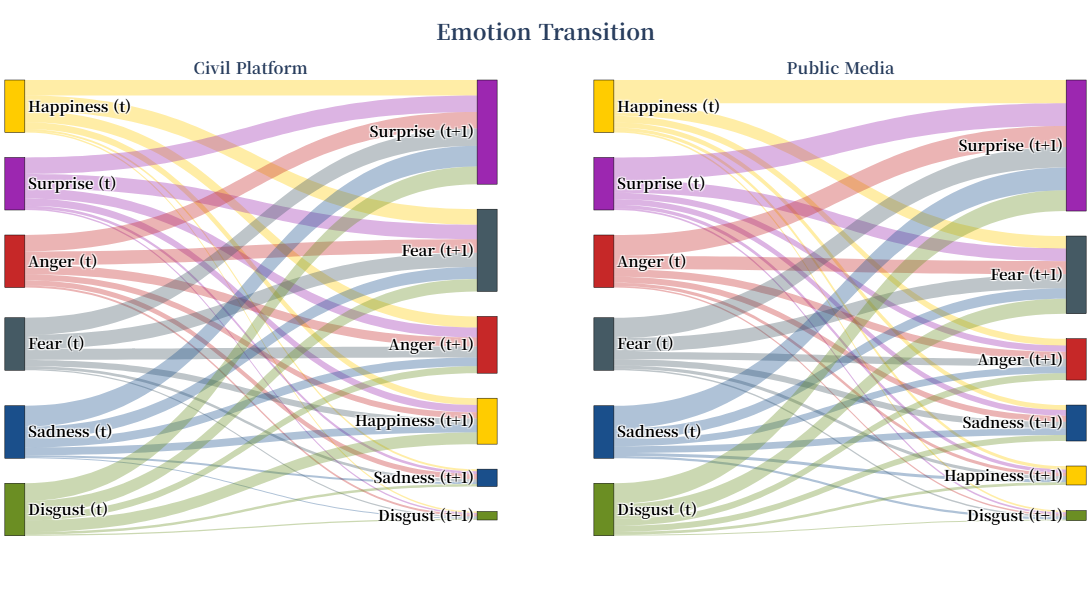

C:\Users\LBaDos\AppData\Local\Temp\ipykernel_33216\920282063.py:111: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).


C:\Users\LBaDos\AppData\Local\Temp\ipykernel_33216\920282063.py:112: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).


C:\Users\LBaDos\AppData\Local\Temp\ipykernel_33216\920282063.py:113: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [13]:
# 1. 왼쪽 노드(source)의 y좌표를 정의 (양쪽 그래프 공통)
source_positions = {
    'Happiness': 0.01,
    'Surprise':  0.2,
    'Anger':     0.4,
    'Fear':      0.6,
    'Sadness':   0.8,
    'Disgust':   0.89
}

# 2. Civil 그래프의 오른쪽 노드(target) y좌표를 정의
civil_target_positions = {
    'Surprise':  0.01,
    'Fear':     0.3,
    'Anger':  0.5,
    'Happiness': 0.7,
    'Sadness' : 0.8,
    'Disgust' : 0.9
}

# 3. Public 그래프의 오른쪽 노드(target) y좌표를 정의
public_target_positions = {
    'Surprise': 0.01,
    'Fear':     0.2,
    'Anger':  0.4,
    'Sadness': 0.6,
    'Happiness' :0.8,
    'Disgust':0.99
}
# (civil_matrix와 public_matrix는 이미 존재한다고 가정)
# 4. 수정한 함수를 새로운 인자들과 함께 호출
create_fully_manual_sankey(
    civil_matrix=civil_matrix,
    public_matrix=public_matrix,
    source_y_positions=source_positions,
    civil_target_y_positions=civil_target_positions,
    public_target_y_positions=public_target_positions,
    threshold=0.00
)